# OHP Experience

## Table of Contents

1. [Alpy](#1-alpy)	
	1. [Setting](#11-setting)
	2. [Calibration](#12-calibration)
		1. [First view at the target](#121-first-view-at-the-target)
		2. [Calibrate the lamp](#122-calibrate-the-lamp)
		3. [Flat](#123-flat)
	3. [Correlation](#13-correlation)

---

## 1. Alpy

### 1.1 Setting

Import packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from scipy.optimize import curve_fit
import scipy.ndimage as ndimage
import os

Implement functions for the script:
  - `fastplot` : Makes a simple plot
  - `showfits` : Prints fits image
  - `targetDatafit` : Extracts data from fits and print a row image
  - `RotCor` : Corrects the inclination of the spectrum, making a linear fit

More details are reported in the file `./script/functions.py`

In [3]:
from matplotlib.colors import LogNorm
from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans
from scipy.signal import correlate

# Take path of the folder
pwd = os.getcwd()

##*
def fastplot(x : np.typing.ArrayLike, y : np.typing.ArrayLike,
			 numfig=None, title='', labels=['',''], dim=[10,7]):
	"""`fastplot(x, y, numfig, title, labels, dim)`

	Function to have a simple plot quickly.
	You can choose to make a simple plot or add a title and some labels.

	I wrote it only because of my laziness in writing code.

	:type x: np.typing.ArrayLike
	:param x: Data on x axis

	:type y: np.typing.ArrayLike
	:param y: Data on y axis

	:type numfig: int or None
	:param numfig: optional.
	  Number of the generated figure. Default is `None`.

	:type title: str
	:param title: optional.
	  Title of the figure. Default is `' '`

	:type labels: list[str, str]
	:param labels: optional.
	  `x` and `y` labels. The format is `[xlabel, ylabel]`.
	  Default is `['','']`

	:type dim: list[int, int]
	:param dim: optional.
	  The dimension of the image to pass to `figsize` parameters of `plt.figure` function.
	  Default is `[10,7]`

	:return: The plot of data
	:rtype: None

	"""
	xl,yl = labels
	plt.figure(numfig,figsize=dim)
	plt.title(title)
	plt.plot(x,y)
	plt.xlabel(xl); plt.ylabel(yl)
	return
##*

##* 
def hotpxRemove(data):
	"""`hotpxRemove(data)`

	Function to remove hot px from the images
	
	Taken by [*astropy documentation*](https://docs.astropy.org/en/stable/convolution/index.html)

	## Parameters

	`data`: array_like
	  image matrix
	
	## Return

	The image matrix without hot pixels

	"""
	kernel = Gaussian2DKernel(x_stddev=1)
	return interpolate_replace_nans(data, kernel)
##*

##*
def showfits(data,title='',n=None,dim=[10,7]):
	"""`showfits(data,title,n,dim)`

	Function to print the fits image.
	  You can print simply the image or set a figure number and a title.

	## Parameters

	`data` : array_like
	  image matrix of fits file
	`title` : str, optional
	  title of the image. Default is `''`
	`n` : int, optional
	  figure number. Default is `None`
	`dim` : list, optional
	  the dimension of the image to pass to `figsize` parameters of `plt.figure` function.
	  Default is `[10,7]`
	
	## Return

	`None`

	The image in grayscale
	"""
	plt.figure(n,figsize=dim)
	plt.title(title)
	plt.imshow(data, cmap='gray')#, norm=LogNorm())#,vmin=2E3,vmax=3E3)
	plt.colorbar()
	return
##*

##* 
def targetDatafit(path,title='',lims=[],hotpx=False):
	"""`targetDatafit(path,title,lims,hotpx)`
	
	Function to open fits file and extract data.
	  It brings the path and exacts the data, giving a row image.
	  You can set a portion of image and also the correction for hotpx.

	  It calls the functions `hotpxRemove` and `showfits`.

	## Parameters

	`path` : str
	  path of the fits file to open
	`title` : str, optional
	  title of the image in `showfits`. Default is `''`
	`lims` : list, optional
	  list with the limits on `x` and `y` axis to get a portion of the image.
 	  The format is [ly,ry,lx,rx]:
 	     - ly -> left  y limit 
 	     - ry -> right y limit 
 	     - lx -> left  x limit 
 	     - rx -> right x limit
	     
	  Default is `[]`
	`hotpx` : bool, optional
	  if it's `True` the correction for hotpx will be.
	  Default is `False`

	## Returns

	`hdul` : astropy.hdulist_like
	  hdul list of the chosen fits file
	`data` : array_like
	  image matrix 
	"""
	# open the file
	hdul = fits.open(path)
	# print fits info
	hdul.info()

	# Data extraction
	# format -> data[Y,X]
	data = hdul[0].data
	if(lims!=[]):
		ly,ry,lx,rx = lims
		data = data[ly:ry,lx:rx]
	# hot px correction
	if(hotpx==True):
		data = hotpxRemove(data)

	# Spectrum image
	showfits(data,title)

	return hdul,data
##*

##*
def RotCor(data):
	"""`RotCor(data)`
	
	Function to correct the inclination, rotating the image.
	  It takes the maximum of each column and does a fit to find the angle with the horizontal.

	## Parameter

	`data` : array_like
	  image matrix

	## Returns

	`angle` : float
	  the angle of the slope
	`data_rot` : array_like
	  rotated image matrix 
	"""
	nx = len(data[0,:])
	mean_val = np.array([])
	for i in range(nx):
		tmp  = data[:,i]
		tmp2 = np.where(tmp == max(tmp))
		tmp2 = tmp2[0]
		if(len(tmp2)>1):
			tmp2 = tmp2.sum()/len(tmp2)
		mean_val = np.append(mean_val,tmp2)
	def fitlin(x,m,q):
		return x*m+q
	initial_values = [0.9,0.]
	for i in range(3):
		pop, pcov = curve_fit(fitlin,range(nx),mean_val,initial_values)
		m = pop[0]
		initial_values = pop

	angle = np.arctan(m)*180/np.pi   # degrees
	data_rot  = ndimage.rotate(data, angle, reshape=False)

	return angle, data_rot
##*


##* 
def initialization(target_file,calibration_file,jupiter_file,flat_file):
	"""`initialization(target_file,calibration_file,jupiter_file,flat_file)`

	Makes the calibration on Beta Lyr spectrum and calculates the flat correction.

	## Parameters

	`target_file` : str
	  name of Beta Lyr fits file
	`calibration_file` : str
	  name of lamp fits file in Beta Lyr folder
	`jupiter_file` : str
	  name of Jupiter fits file
	`flat_file` : str
	  name of Flat fits file

	## Returns

	`values` : array_like			
	  calibrated values array of Beta Lyr spectrum with flat
 	`stdLamp` : array_like
	  values array for the Lamp of Beta Lyr, used for calibration 
	`dataJup` : array_like		
	  rotated image matrix of Jupiter
	`angleJup` : array_like
	  the angle of slope for Jupiter data
	`Flat` : float			
	  flat correction value
 	`TransferFunc` : function
	  function to pass from px to lambda 	  	
	"""
	ly,ry = [650,1400]
	lx,rx = [760,-1]
	cut   = [ly,ry,lx,rx]

	##* Open target image
	print('Open the Target Fits File\n')
	# data[Y,X]
	hdul, data = targetDatafit(target_file,title='$\\beta$ Lyr',lims=cut,hotpx=True)
	hdul[0].header['OBJECT'] = 'Beta Lyr'
	# rotation
	angle, data = RotCor(data)
	nx = len(data[0,:]); ny = len(data[:,0])
	showfits(data,f'$\\beta$ Lyr - Rotated of {angle} degrees')
	# sum in a range of the spectrum
	values = np.array([data[555:574,j].sum() for j in range(nx) ])
	# plot
	fastplot(np.linspace(0,nx,nx),values,title='Spectrum without calibration and flat correction',labels=['x [px]','counts'])
	hdul.close()

	##* Open calibration lamp
	print('\n\nOpen the Calibration Fits File\n')
	hdul, Cdata = targetDatafit(calibration_file,title='Calibration Lamp',lims=cut)
	# rotation
	Cdata = ndimage.rotate(Cdata,angle,reshape=False)
	showfits(Cdata,f'Calibration Lamp - Rotated of {angle} degrees')
	# Spectrum
	Cvalues = Cdata[350,:]
	if(nx != len(Cdata[0,:])):
		print(f'Data Error -> Different Shape of Images after Rotation\nTarget\tLamp\n{nx}\t{len(Cdata[0,:])}')
		return 
	# plot
	fastplot(range(nx),Cvalues,title='Lamp spectrum',labels=['x [px]','counts'])
	## Fit
	fold = 'C:/Users/berna/Desktop/FISICA/ASTROFISICA/#OHP_France/26072022/'
	lA, lpx = np.loadtxt(fold+'betaLyr/calibration_lines.txt',unpack=True)
	def FitFun(x,p0,p1,p2,p3):
		return p0 + p1*x + p2*x**2 + p3*x**3
	initial_values = np.array([1e2,1.,0.,0.])
	for i in range(3):
		pop, pcov = curve_fit(FitFun,lpx,lA,initial_values)
		p0,p1,p2,p3 = pop
		initial_values = pop
	error = np.array([np.sqrt((data[i,:]).sum()) for i in range(4)])
	def TransferFunc(Lpx):
		return FitFun(Lpx,p0,p1,p2,p3)
	# plot the fit
	plt.figure()
	xx = np.linspace(0,max(lpx)+100,1000)
	plt.subplot(121)
	plt.title('Fit')
	plt.plot(lpx,lA,'.')
	plt.plot(xx,TransferFunc(xx))
	plt.subplot(122)
	plt.plot(lpx,abs(1-TransferFunc(lpx)/lA),'.')
	plt.plot([min(lpx),max(lpx)],[0,0],'--')

	# plot spectrum
	px = np.linspace(0,nx,nx)
	l = TransferFunc(px)
	fastplot(l,values,title='Calibrated Spectrum of $\\beta$ Lyr without flat correction',labels=['$\lambda$ [A]','counts'])

	hdul.close()

	##* Flat
	print('Open Flat Fits File\nFlat')
	hdulFlat, dataFlat = targetDatafit(fold+'giove/'+flat_file+'.fit',lims=cut)
	print('Jupiter')
	hdulJup, dataJup   = targetDatafit(fold+'giove/'+jupiter_file+'.fit',lims=cut)
	# Rot
	angleJup, dataJup = RotCor(dataJup)
	dataFlat = ndimage.rotate(dataFlat,angleJup,reshape=False)
	if(nx != len(dataFlat[0,:])):
		print(f'Data Error -> Different Shape of Images after Rotation\nTarget\Flat\n{nx}\t{len(dataFlat[0,:])}')
		return
	# calculate flat
	Flat = np.array([dataFlat[:,j].sum() for j in range(nx)])/dataFlat.sum()
	
	# Spectrum calibrated with flat
	fastplot(l,values/Flat,title='Calibrated Spectrum of $\\beta$ Lyr with flat correction',labels=['$\lambda$ [A]','counts'])

	hdulFlat.close()
	hdulJup.close()
	stdLamp = Cvalues
	return values, stdLamp, dataJup, angleJup, Flat, TransferFunc
##*

##*
def Correlation(values,stdLamp):
	corr = correlate(stdLamp,values)/np.sqrt((values**2).sum()*(stdLamp**2).sum())
	corr = max(corr)
	pos = lambda x : np.where( x == max(x))
	return
##*

##*
def OpenSpect():
	return
##*





Collect data files in `data_files/26072022/`

In [4]:


folder_name = os.path.join('data_files','26072022')
fold = os.path.split(pwd); fold = fold[0]
fold0 = os.path.join(fold, folder_name,'')	

'''
In the file `targets.txt` the names of the fits data for the various targets. We took for each observation a lamp calibration.
	name	matrix with 3 columns:
				[0] name of fits file target 
				[1] calibration lamp fits 
				[2] flat (only for Jupiter) 
This is the index of rows:
	 [0]	Beta Lyr
	 [1]	Gamma Cyg
	 [2]	Jupiter		with flat
	 [3]	Moon White face	no calibration lamp
	 [4]	Moon Black face
	 [5]	Moon Black face only IMAGE
	 [6]	M57
	 [7]	Mars
	 [8]	Pi Cyg
	 [9]	Saturn
	[10]	Saturn only IMAGE
	[11]	Vega
	[12]	WR137
'''
#names = pd.read_csv('./'+ folder_name +'/targets.csv',sep='\t')
names = pd.read_csv(fold0 +'targets.csv',sep='\t')
names = pd.DataFrame(names).to_numpy() 
folders = ['betaLyr','gammaCygni','giove','luna','luna','luna','m57','marte','pyCygni','saturno','saturno','vega','wr137']


### 1.2 Calibration

Take one object arbitrally and using the lines of the lamp NeAr in `calibration_lines.txt` fit the transmission function that converts px to lambda.

#### 1.2.1 First view at the target

I chose the target [0] and plot the spectrum in px

Filename: /home/bernardo/Scrivania/FISICA/ASTROFISICA/Astr_Oss/Progetti/proj_3/data_files/26072022/betaLyr/betaLyr_alpy_26072022_0250.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      35   (2749, 2199)   int16 (rescales to uint16)   
Filename: /home/bernardo/Scrivania/FISICA/ASTROFISICA/Astr_Oss/Progetti/proj_3/data_files/26072022/betaLyr/betaLyr_alpy_26072022_0250.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      35   (2749, 2199)   uint16   
1988
1988


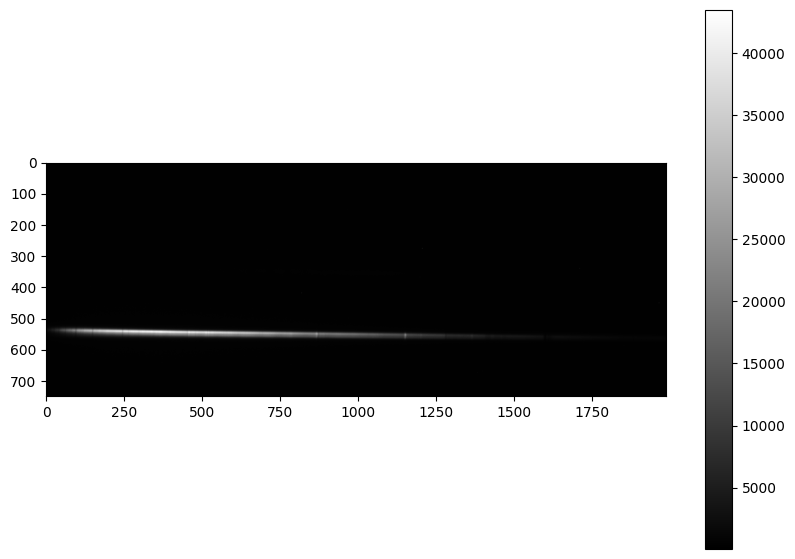

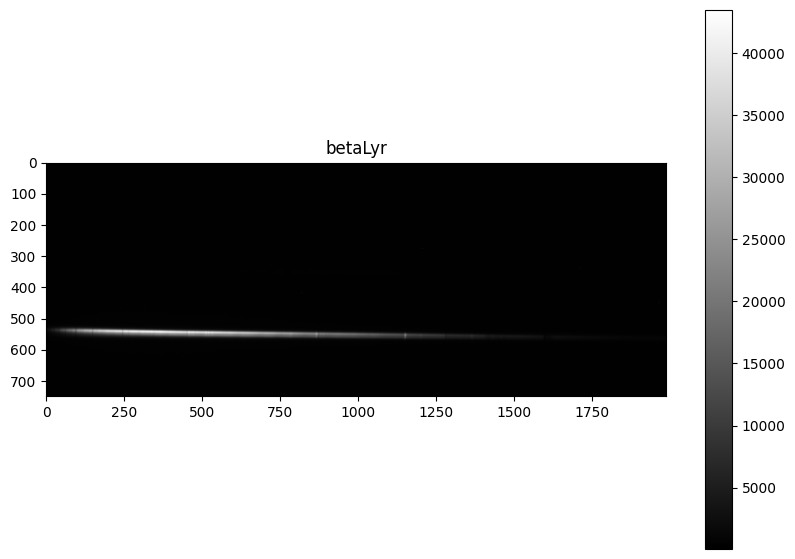

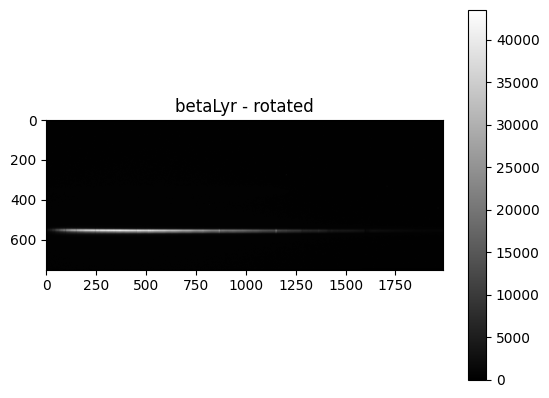

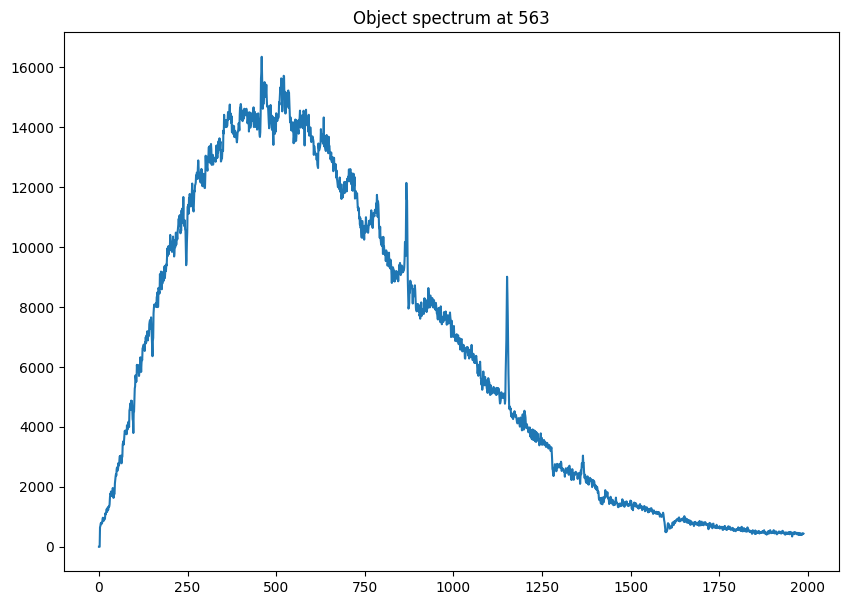

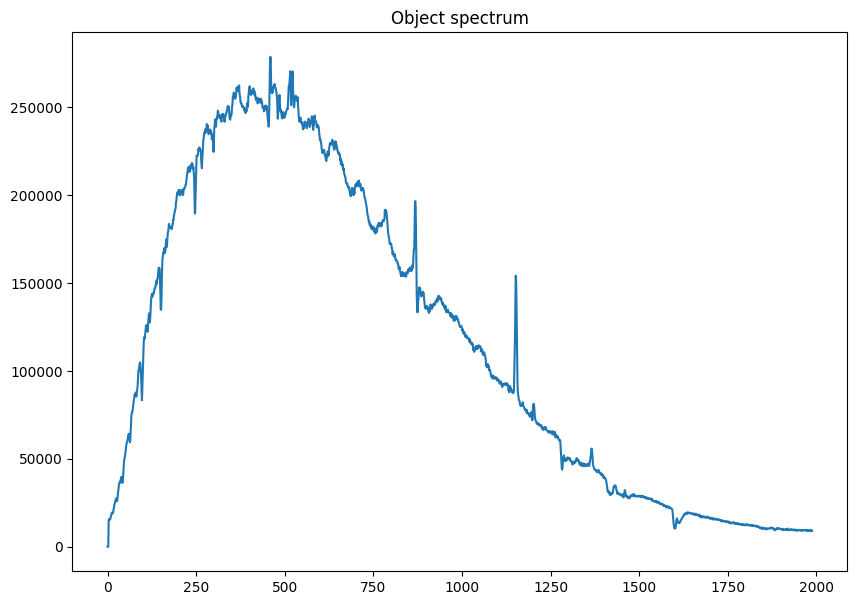

In [5]:
obj_ind = 0

target_file = names[obj_ind][0]
calibration_file = names[obj_ind][1]
fold = fold0 + os.path.join(folders[obj_ind],'')

# lambda function to open fits
path = lambda name : fold + name + '.fit'

# Set the cut
ly,ry = [650,1400]
lx,rx = [760,-1]

## Open target image
# data[Y,X]
hdul, data = targetDatafit(path(target_file),lims=[ly,ry,lx,rx],hotpx=True)
nx = len(data[0,:]); ny = len(data[:,0])

hdul[0].header['OBJECT'] = 'Beta Lyr'
hdul.info()

print(nx)


# Spectrum image
showfits(data,folders[obj_ind])



# rotation correction
# rotate the image
angle, data_rot = RotCor(data)

# plot
plt.figure()
plt.title(folders[obj_ind]+' - rotated')
plt.imshow(data_rot, cmap='gray')
plt.colorbar()

# spectrum graph
data = data_rot
cut = 563
values = data[cut,:]
nx = len(data[0,:]); ny = len(data[:,0])
print(nx)

# remove noise
# values -= data[350,:]

# plot at cut
fastplot(np.linspace(0,nx,nx),values,title=f'Object spectrum at {cut}')

# sum in a range of the spectrum
values = np.array([data[555:574,j].sum() for j in range(nx) ])

# remove noise
# values -= data[350,:]

# plot
fastplot(np.linspace(0,nx,nx),values,title='Object spectrum')

plt.show()


hdul.close()

#### 1.2.2 Calibrate the lamp

Make a fit for the lines with a polynom of 3rd order and plot the spectrum of the obj in lambda.

Then make a table with the lines.

Filename: /home/bernardo/Scrivania/FISICA/ASTROFISICA/Astr_Oss/Progetti/proj_3/data_files/26072022/betaLyr/betaLyr_alpy_lamp_26072022_0250.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      35   (2749, 2199)   int16 (rescales to uint16)   
1988 1988


/tmp/ipykernel_23764/2856907544.py:58: RuntimeWarning: invalid value encountered in sqrt
  error = np.array([np.sqrt((pcov[i,:]).sum()) for i in range(4)])


[ 3.68454323e+03  2.54216802e+00 -1.14929184e-05 -3.29918443e-08] [11.53302683         nan  0.01944174         nan]


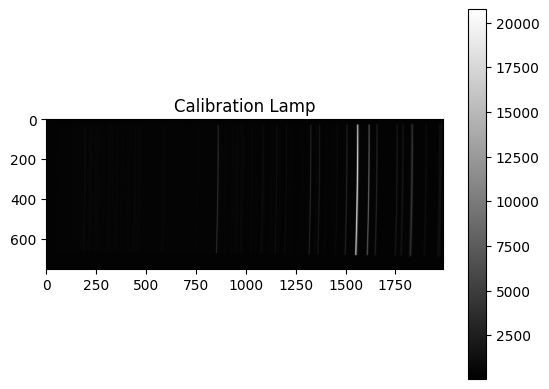

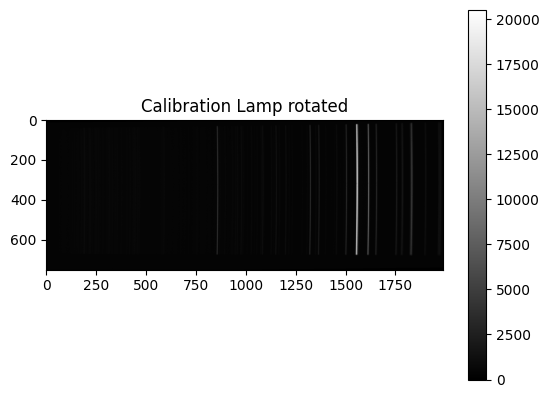

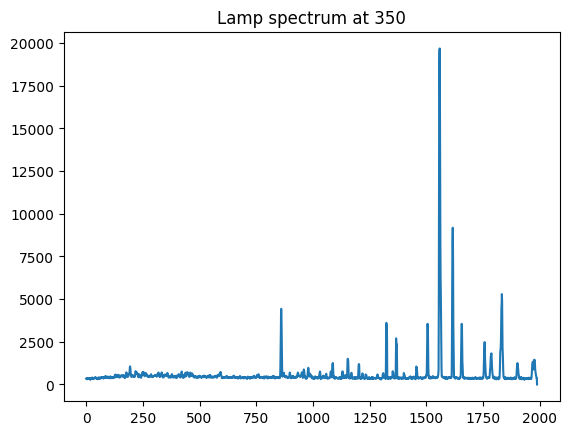

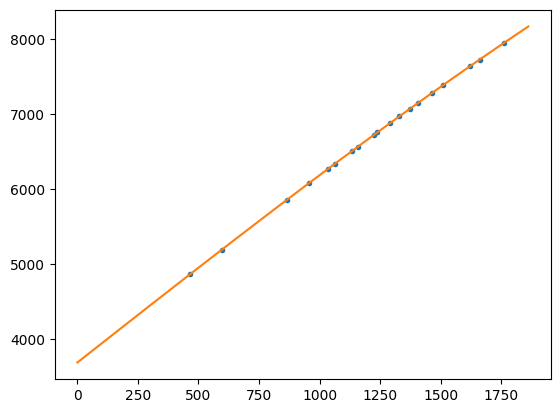

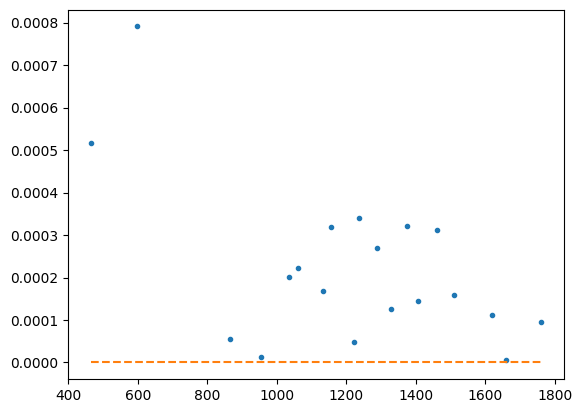

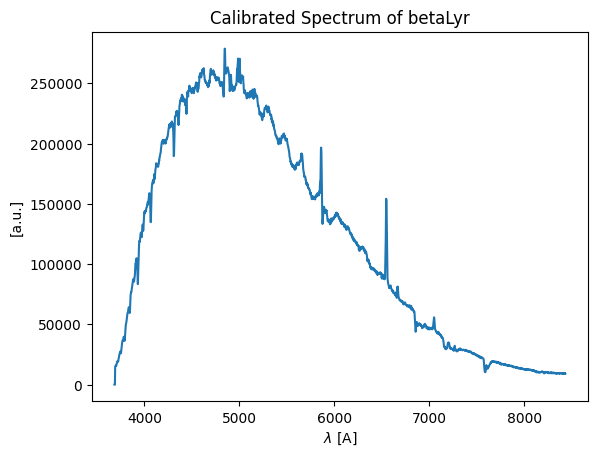

<class 'numpy.ndarray'>
<class 'function'>


In [6]:
# Open calibraion file
hdul = fits.open(path(calibration_file))

hdul.info()

# data[Y,X]
cdata = hdul[0].data
cdata = cdata[ly:ry,lx:rx]
cnx = len(cdata[0,:]); cny = len(cdata[:,0])

print(nx,cnx)
cdata_rot = ndimage.rotate(cdata, angle, reshape=False)


# Spectrum image
plt.figure()
plt.title('Calibration Lamp')
plt.imshow(cdata, cmap='gray')
plt.colorbar()

plt.figure()
plt.title('Calibration Lamp rotated')
plt.imshow(cdata_rot, cmap='gray')
plt.colorbar()


# spectrum graph
cdata = cdata_rot
cut = 350
cvalues = cdata[cut,:]
cnx = len(cdata[0,:]); cny = len(cdata[:,0])


plt.figure()
plt.title(f'Lamp spectrum at {cut}')
plt.plot(np.linspace(0,cnx,cnx),cvalues)



## Fit
lA, lpx = np.loadtxt(fold+'calibration_lines.txt',unpack=True)

def FitFun(x,p0,p1,p2,p3):
	return p0 + p1*x + p2*x**2 + p3*x**3

initial_values = np.array([1e2,1e1,1.,0.])
pop, pcov = curve_fit(FitFun,lpx,lA,initial_values)
p1,p2,p3,p4 = pop
Dp1,Dp2,Dp3,Dp4 = np.sqrt(pcov.diagonal())

for i in range(2):
	initial_values = pop
	pop, pcov = curve_fit(FitFun,lpx,lA,initial_values)
	p1,p2,p3,p4 = pop
	Dp1,Dp2,Dp3,Dp4 = np.sqrt(pcov.diagonal())


error = np.array([np.sqrt((pcov[i,:]).sum()) for i in range(4)])
print(pop,error)

plt.figure()
xx = np.linspace(0,max(lpx)+100,1000)
plt.plot(lpx,lA,'.')
plt.plot(xx,FitFun(xx,p1,p2,p3,p4))

plt.figure()
plt.plot(lpx,abs(1-FitFun(lpx,p1,p2,p3,p4)/lA),'.')
plt.plot([min(lpx),max(lpx)],[0,0],'--')

##! True target spectrum
px = np.linspace(0,nx,nx)
l = FitFun(px,p1,p2,p3,p4)

plt.figure()
plt.title('Calibrated Spectrum of ' + folders[obj_ind])
plt.xlabel('$\lambda$ [A]'); plt.ylabel('[a.u.]')
plt.plot(l,values)

plt.show()

print(type(px))
print(type(FitFun))
hdul.close()


#### 1.2.3 Flat

Open the flat and Jupiter files, adjust rotation and take the normalized flat.

Then plot the corrected spectrum.

Filename: /home/bernardo/Scrivania/FISICA/ASTROFISICA/Astr_Oss/Progetti/proj_3/data_files/26072022/giove/giove_flat_alpy_26072022.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      35   (2749, 2199)   int16 (rescales to uint16)   
Filename: /home/bernardo/Scrivania/FISICA/ASTROFISICA/Astr_Oss/Progetti/proj_3/data_files/26072022/giove/giove_alpy_26072022_0116.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      35   (2749, 2199)   int16 (rescales to uint16)   
1988
1988
0.6810687149950692 1.2444388492436464
1988 1988 1988


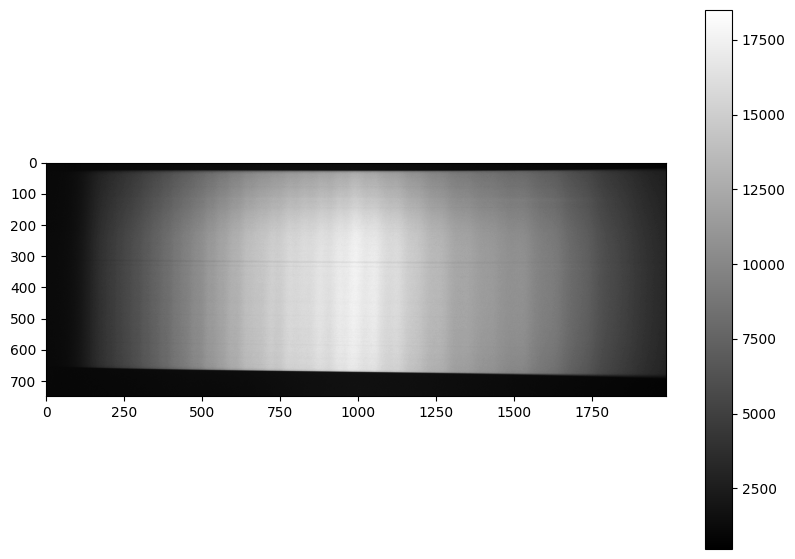

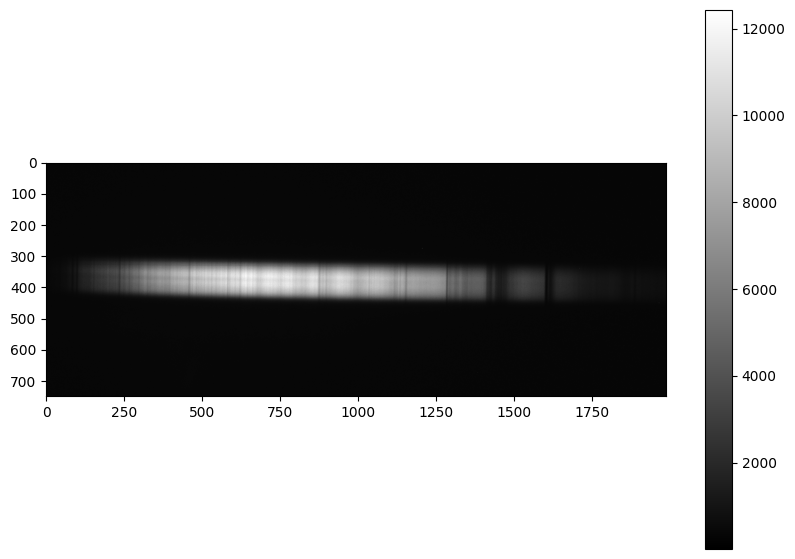

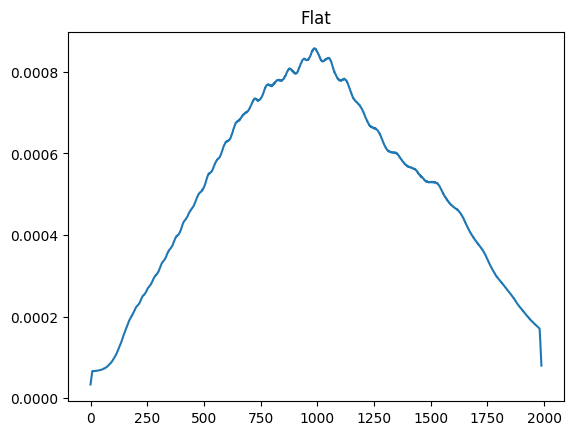

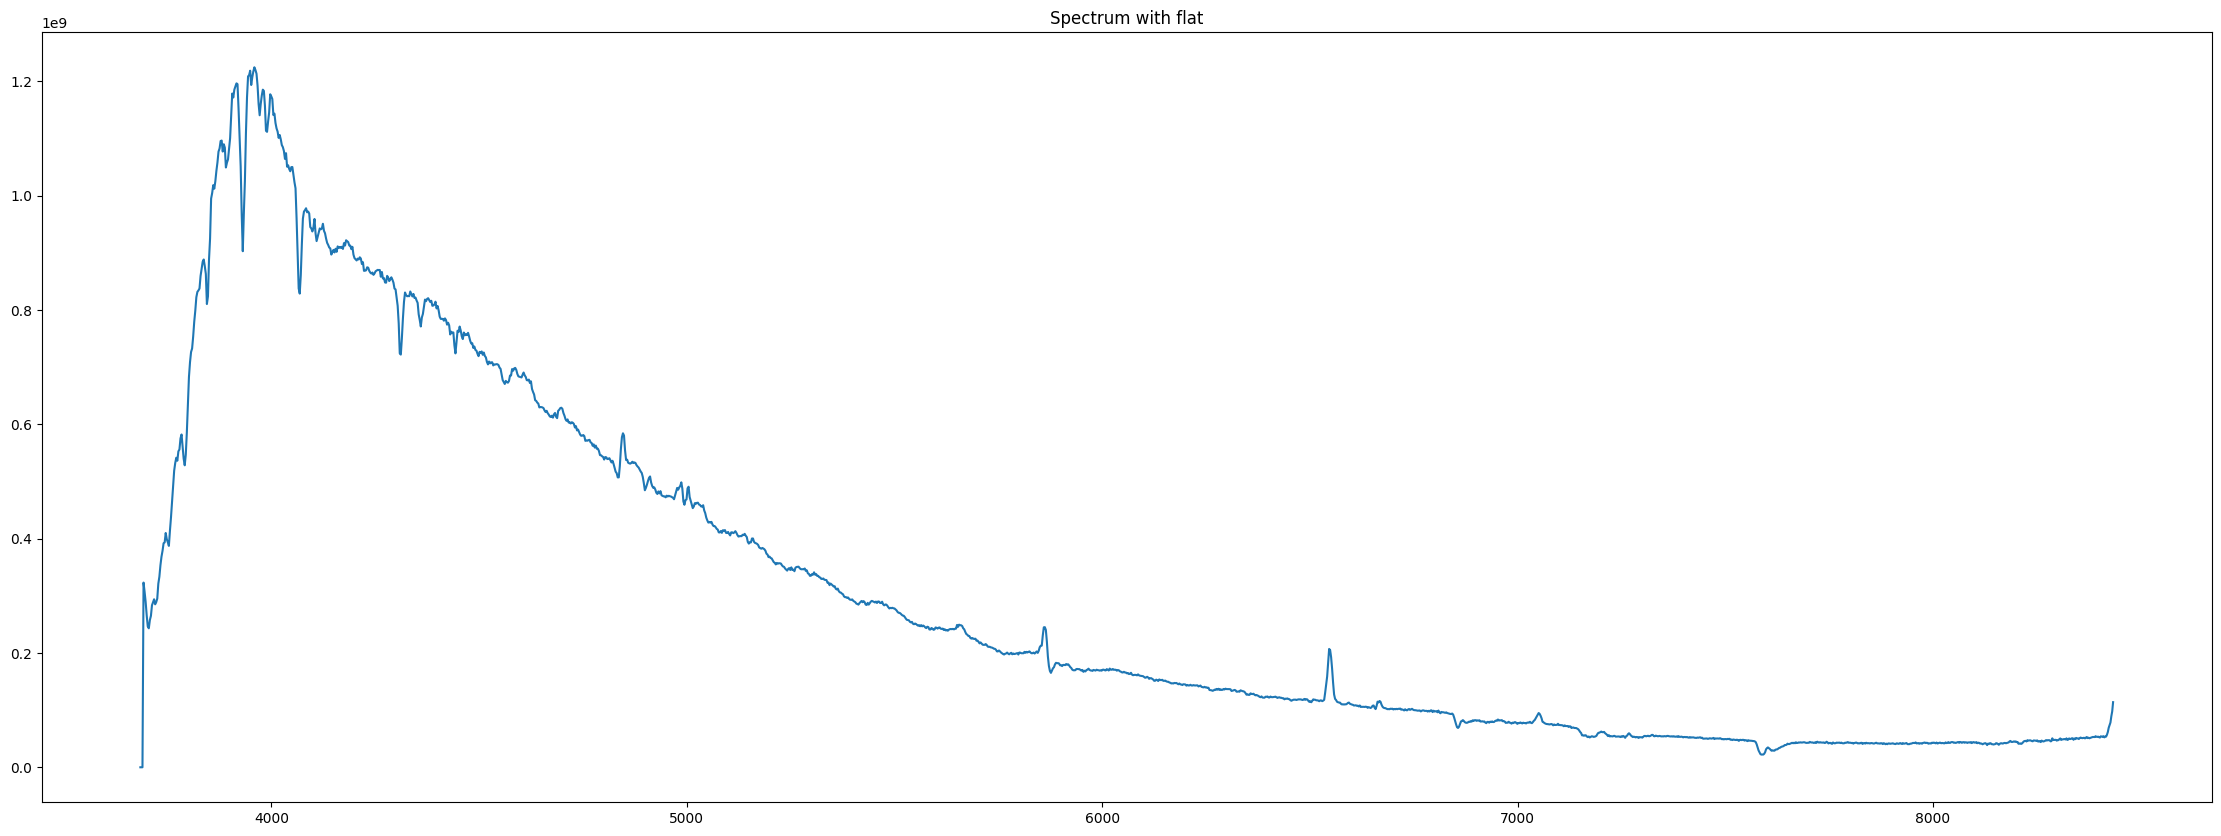

In [7]:
hdulFlat, dataFlat = targetDatafit(fold0+'giove/'+names[2][2]+'.fit',lims=[ly,ry,lx,rx])
hdulJup, dataJup   = targetDatafit(fold0+'giove/'+names[2][0]+'.fit',lims=[ly,ry,lx,rx])

print(len(dataFlat[0,:]))
angleJup, dataJup = RotCor(dataJup)
dataFlat = ndimage.rotate(dataFlat,angleJup,reshape=False)
print(len(dataFlat[0,:]))


nxf = len(dataFlat[0,:]); nyf = len(dataFlat[:,0])

print(angle,angleJup)
print(nx,cnx,nxf)



valuesFlat = np.array([dataFlat[:,j].sum() for j in range(nxf)])

flat = dataFlat.sum()

# Flat
flat = valuesFlat/flat

plt.figure()
plt.title('Flat')
plt.plot(np.linspace(0,nxf,nxf),flat)

plt.figure(figsize=[28,10])
plt.title('Spectrum with flat')
plt.plot(l,values/flat)

plt.show()

### 1.3 Correlation

Now choose another target and maximize the convolution between the previous lamp spectrum and the this one to get the shift of the picks.

Filename: /home/bernardo/Scrivania/FISICA/ASTROFISICA/Astr_Oss/Progetti/proj_3/data_files/26072022/vega/vega_alby_26072022_0327.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      36   (2749, 2199)   int16 (rescales to uint16)   
Filename: /home/bernardo/Scrivania/FISICA/ASTROFISICA/Astr_Oss/Progetti/proj_3/data_files/26072022/vega/vega_alby_lamp_26072022_0327.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      36   (2749, 2199)   int16 (rescales to uint16)   
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
0.0010150129396375783


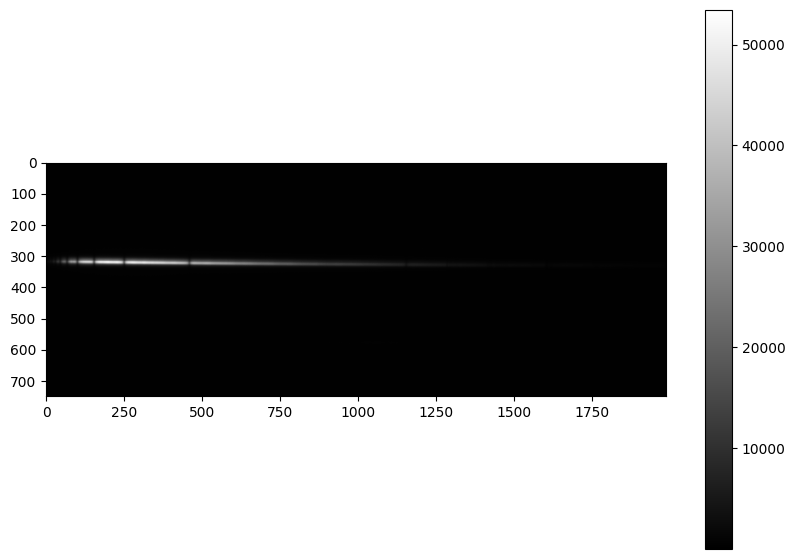

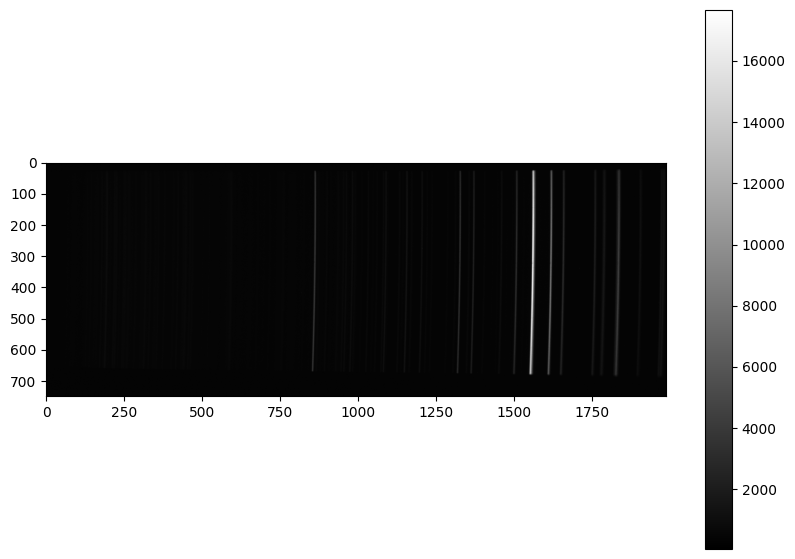

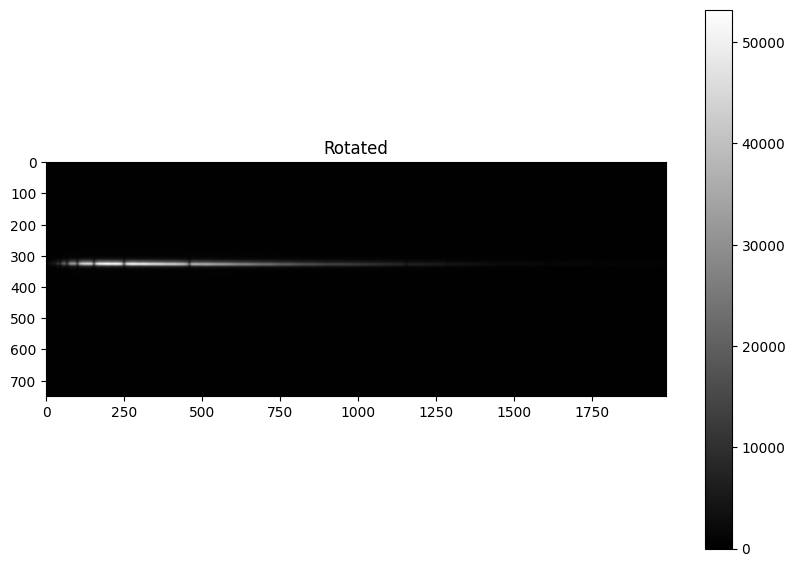

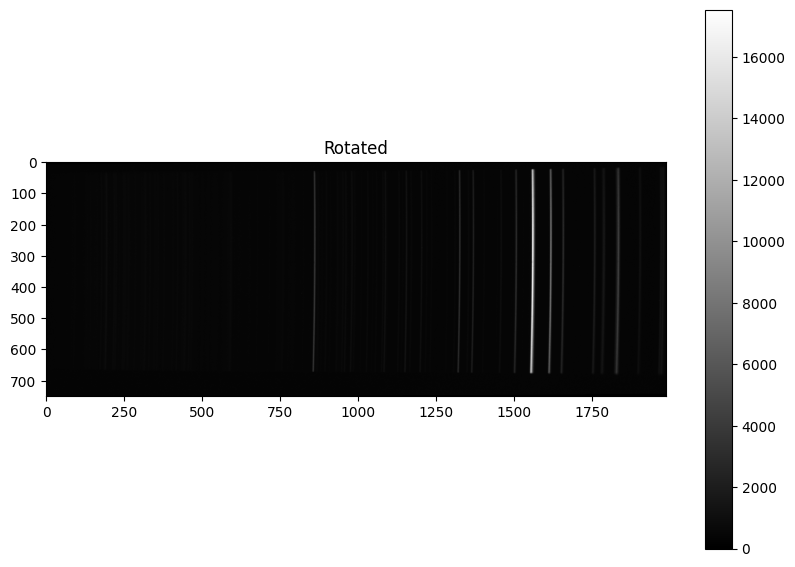

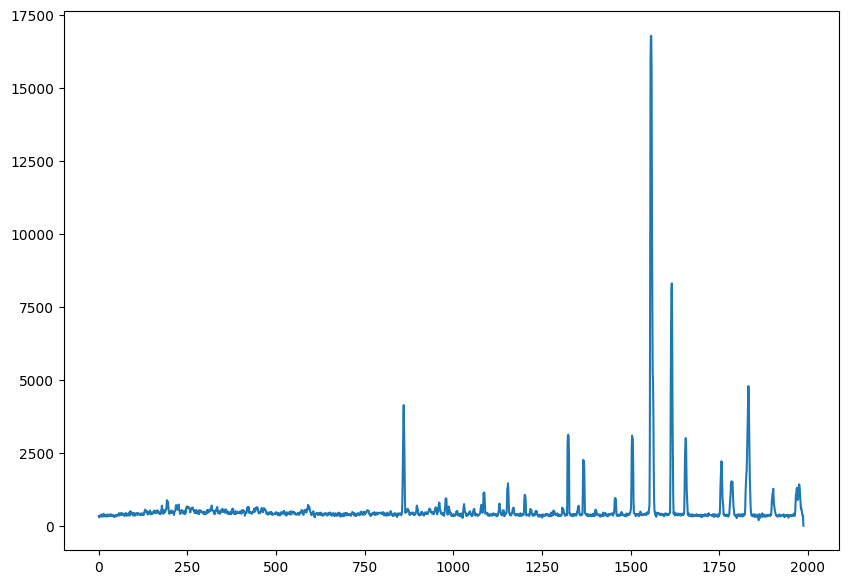

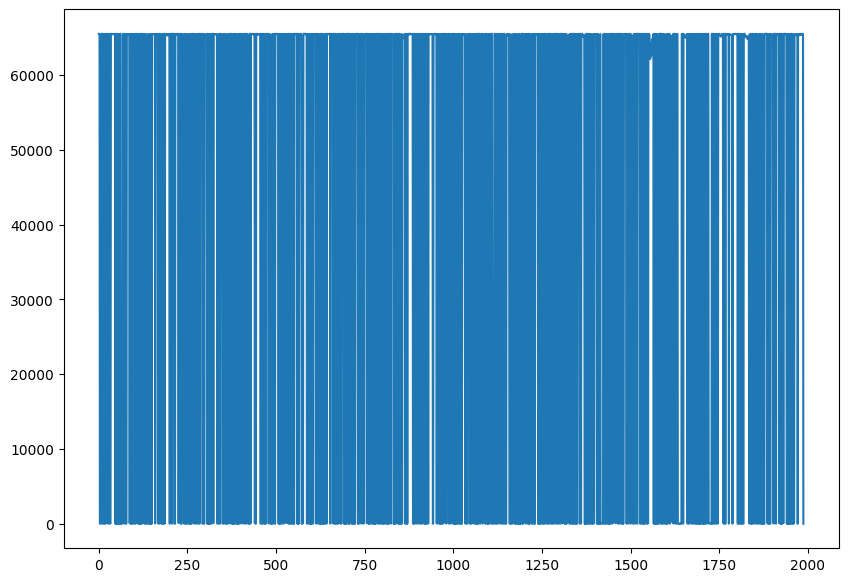

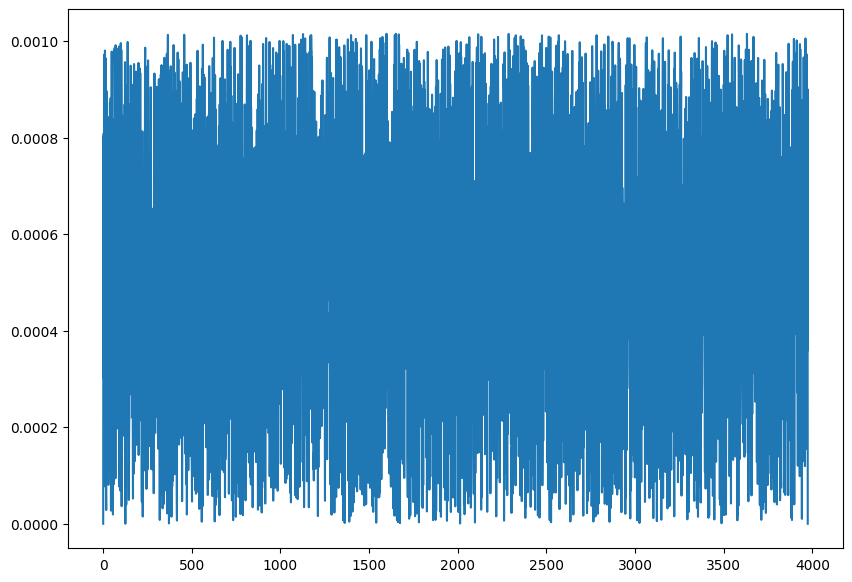

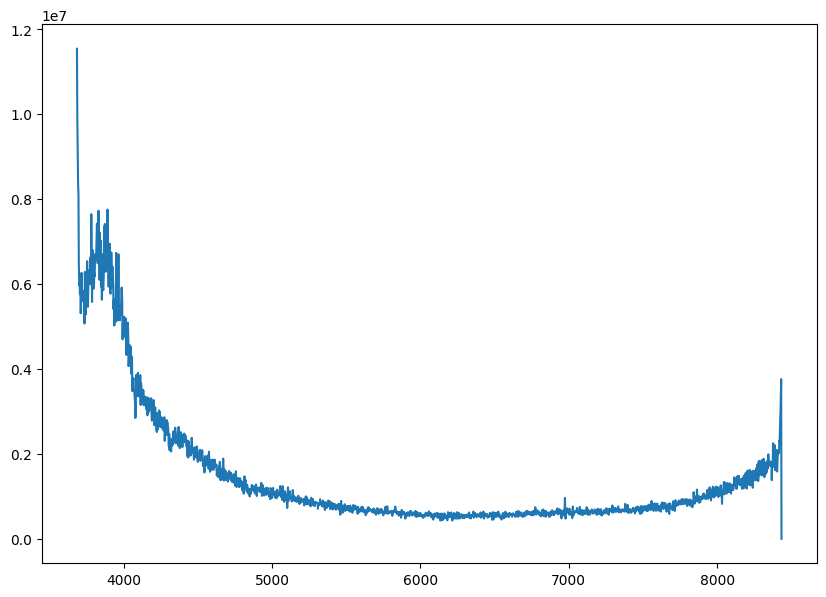

In [8]:
from scipy.signal import correlate

obj_ind = 11

target_file = names[obj_ind][0]
calibration_file = names[obj_ind][1]
fold = fold0 + folders[obj_ind]+'/'

# function to open fits
path = lambda name : fold + name + '.fit'

hdul1,data1 = targetDatafit(path(target_file),lims=[ly,ry,lx,rx])
hdul2,data2 = targetDatafit(path(calibration_file),lims=[ly,ry,lx,rx])

print(type(data))

angle, data1 = RotCor(data1)
data2 =  ndimage.rotate(data2, angle, reshape=False)

showfits(data1,title='Rotated')
showfits(data2,title='Rotated')


## Correlation
# set the fit lamp values as a standard
stdLamp = cvalues
stdnx   = len(stdLamp)

values2 = data2[cut,:]
nx2 = len(values2)

print(type(values2))

fastplot(range(nx2),values2)
fastplot(range(nx2),values2-stdLamp)


corr = correlate(stdLamp,values2)/np.sqrt((values2**2).sum()*(stdLamp**2).sum())#nx2
print(max(corr))
fastplot(range(len(corr)),corr)

corr = max(corr)
tmppos = lambda x : np.where(x == max(x))

x = np.linspace(0,nx2,nx2)
if( tmppos(values2)[0]-tmppos(stdLamp)[0]>0 ):
	x -= corr
else:
	x += corr

l2 = FitFun(x,p1,p2,p3,p4)

fastplot(l2,data1[cut,:]/flat)

plt.show()